In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scipy import stats

In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
df = pd.read_csv('/content/saderat_bank.csv')

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
df

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,Saderat Bank,20241126,1962.0,1962.0,1850.0,1930.0,1.319969e+12,684058039,7853,D,1905.0,1865.0
1,Saderat Bank,20241125,1905.0,1905.0,1873.0,1905.0,5.028978e+11,263993639,2426,D,1850.0,1905.0
2,Saderat Bank,20241124,1829.0,1851.0,1815.0,1850.0,4.475030e+11,241896657,2161,D,1798.0,1851.0
3,Saderat Bank,20241123,1770.0,1801.0,1749.0,1798.0,5.691964e+11,316643947,3671,D,1749.0,1801.0
4,Saderat Bank,20241120,1746.0,1788.0,1746.0,1749.0,4.129098e+11,236049692,2826,D,1800.0,1746.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3731,Saderat Bank,20090614,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423,1995,D,1023.0,1025.0
3732,Saderat Bank,20090613,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223,5411,D,1021.0,1024.0
3733,Saderat Bank,20090610,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812,2406,D,1001.0,1025.0
3734,Saderat Bank,20090609,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500,545,D,1001.0,1001.0


In [51]:
df = df.drop(['<TICKER>'], axis=1)

In [52]:
df = df.rename(columns={'<DTYYYYMMDD>': 'date', '<HIGH>': 'high','<FIRST>' : 'first', '<LOW>': 'low', '<CLOSE>': 'close', '<VALUE>': 'value',
                        '<VOL>': 'vol', '<OPENINT>': 'openint','<PER>': 'per', '<OPEN>': 'open', '<LAST>': 'last'})

In [53]:
df

,date,first,high,low,close,value,vol,openint,per,open,last
0,20241126,1962.0,1962.0,1850.0,1930.0,1.319969e+12,684058039,7853,D,1905.0,1865.0
1,20241125,1905.0,1905.0,1873.0,1905.0,5.028978e+11,263993639,2426,D,1850.0,1905.0
2,20241124,1829.0,1851.0,1815.0,1850.0,4.475030e+11,241896657,2161,D,1798.0,1851.0
3,20241123,1770.0,1801.0,1749.0,1798.0,5.691964e+11,316643947,3671,D,1749.0,1801.0
4,20241120,1746.0,1788.0,1746.0,1749.0,4.129098e+11,236049692,2826,D,1800.0,1746.0
...,...,...,...,...,...,...,...,...,...,...,...
3731,20090614,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423,1995,D,1023.0,1025.0
3732,20090613,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223,5411,D,1021.0,1024.0
3733,20090610,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812,2406,D,1001.0,1025.0
3734,20090609,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500,545,D,1001.0,1001.0


In [54]:
# Converting 'Volume' from strings with 'M' and 'B' to numerical values
df['vol'] = df['vol'].replace({'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)

In [55]:
# تبدیل تاریخ به فرمت datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
# مرتب‌سازی بر اساس تاریخ از 2009 تا 2024
df = df.sort_values(by='date', ascending=True)

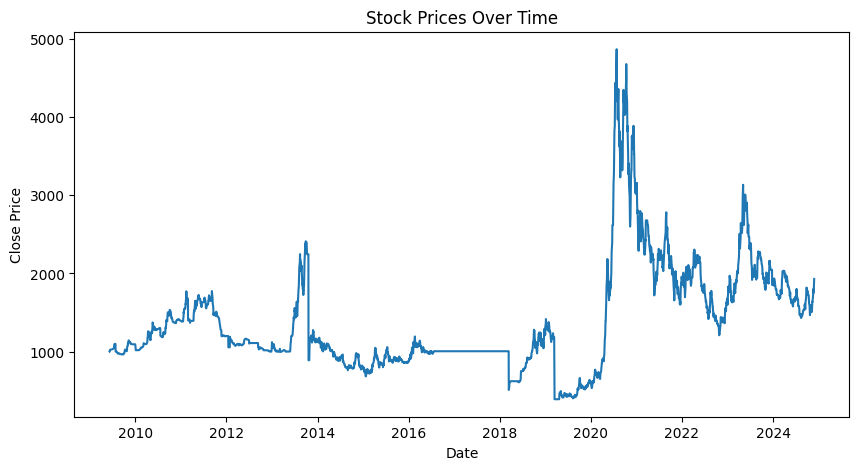

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(False)
plt.show()

تجزیه و تحلیل روند و فصلی بودن داده‌های قیمت بسته شدن



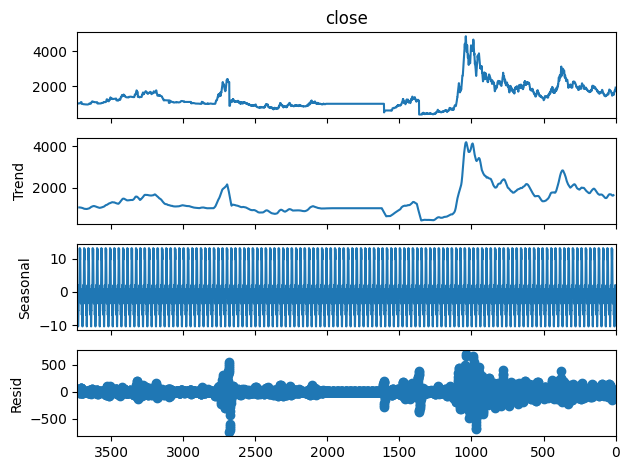

In [57]:
# Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the Closing Price
decomposition = seasonal_decompose(df['close'], model='additive', period=30)  # assuming monthly seasonality

fig = decomposition.plot()
plt.show()


شناخت داده های پرت

In [58]:
# Outlier Detection using Z-Score

z_scores = np.abs(stats.zscore(df['close']))
threshold = 4
outliers = np.where(z_scores > threshold)
print(f"Number of outliers in Closing Price: {len(outliers[0])}")


Number of outliers in Closing Price: 39


In [59]:
# محاسبه میانگین قیمت بسته شدن
mean_close = df['close'].mean()

# جایگزینی داده‌های پرت با میانگین
df['close'] = np.where(np.abs(stats.zscore(df['close'])) > 5, mean_close, df['close'])

# نمایش دیتاست پس از جایگزینی
print(f"Number of rows after replacing outliers with mean: {df.shape[0]}")


Number of rows after replacing outliers with mean: 3736


### Scaling

In [60]:
df

,date,first,high,low,close,value,vol,openint,per,open,last
3735,2009-06-08,0.0,0.0,0.0,1000.0,0.000000e+00,0.0,0,D,1000.0,1000.0
3734,2009-06-09,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500.0,545,D,1001.0,1001.0
3733,2009-06-10,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812.0,2406,D,1001.0,1025.0
3732,2009-06-13,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223.0,5411,D,1021.0,1024.0
3731,2009-06-14,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423.0,1995,D,1023.0,1025.0
...,...,...,...,...,...,...,...,...,...,...,...
4,2024-11-20,1746.0,1788.0,1746.0,1749.0,4.129098e+11,236049692.0,2826,D,1800.0,1746.0
3,2024-11-23,1770.0,1801.0,1749.0,1798.0,5.691964e+11,316643947.0,3671,D,1749.0,1801.0
2,2024-11-24,1829.0,1851.0,1815.0,1850.0,4.475030e+11,241896657.0,2161,D,1798.0,1851.0
1,2024-11-25,1905.0,1905.0,1873.0,1905.0,5.028978e+11,263993639.0,2426,D,1850.0,1905.0


In [61]:
# Scaling the numerical features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Selecting features for scaling (excluding Date and Percentage Change as it is in percentage form)
features_to_scale = ['close', 'open', 'high', 'low', 'vol']

# Initializing the scaler
scaler = MinMaxScaler()

# Scaling the selected features
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Displaying the first few rows to verify scaling
df[['date', 'close', 'open', 'high', 'low', 'vol']].head()


,date,close,open,high,low,vol
3735,2009-06-08,0.141991,0.135968,0.000000,0.000000,0.000000
3734,2009-06-09,0.142224,0.136191,0.196086,0.216199,0.343761
3733,2009-06-10,0.146887,0.136191,0.201761,0.220302,0.018810
3732,2009-06-13,0.147354,0.140656,0.200587,0.217279,0.042231
3731,2009-06-14,0.147587,0.141103,0.200783,0.220086,0.013957


In [62]:
# Print date range of the dataset
print('Date Range:', df['date'].min(), 'to', df['date'].max())

Date Range: 2009-06-08 00:00:00 to 2024-11-26 00:00:00


In [63]:
# Feature Engineering

# Moving Averages
df['MA10'] = df['close'].rolling(window=10).mean()
df['MA50'] = df['close'].rolling(window=50).mean()

# Lag Features
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['close'].shift(lag)

# Volatility (Standard Deviation)
df['Volatility'] = df['close'].rolling(window=10).std()

# Drop rows with NaN values generated by feature engineering
df.dropna(inplace=True)

print(df.head())


           date  first      high       low     close         value       vol  \
3686 2009-08-19  963.0  0.191389  0.207991  0.137328  3.055110e+08  0.000110   
3685 2009-08-22  970.0  0.189824  0.207775  0.137095  4.754206e+08  0.000172   
3684 2009-08-23  970.0  0.189824  0.205616  0.136395  1.180368e+09  0.000430   
3683 2009-08-24  964.0  0.189041  0.206048  0.135929  9.687572e+08  0.000353   
3682 2009-08-25  960.0  0.188063  0.206263  0.135463  7.652826e+08  0.000279   

      openint per      open   last      MA10      MA50     Lag_1     Lag_2  \
3686       32   D  0.131503  965.0  0.137654  0.147288  0.137328  0.137561   
3685       53   D  0.131503  966.0  0.137375  0.147190  0.137328  0.137328   
3684       74   D  0.131279  960.0  0.137118  0.147074  0.137095  0.137328   
3683       62   D  0.130610  960.0  0.137002  0.146855  0.136395  0.137095   
3682       49   D  0.130163  955.0  0.136908  0.146617  0.135929  0.136395   

         Lag_3     Lag_4     Lag_5  Volatility  
3

### Model selection

In [64]:
# Sort the data by 'Date' in ascending order
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(by='date').reset_index(drop=False)

df.reset_index(inplace= True)
df.drop(columns = ['index'], inplace= True)
df


,date,first,high,low,close,value,vol,openint,per,open,last,MA10,MA50,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Volatility
0,2009-08-19,963.0,0.191389,0.207991,0.137328,3.055110e+08,0.000110,32,D,0.131503,965.0,0.137654,0.147288,0.137328,0.137561,0.137561,0.137328,0.137095,0.001015
1,2009-08-22,970.0,0.189824,0.207775,0.137095,4.754206e+08,0.000172,53,D,0.131503,966.0,0.137375,0.147190,0.137328,0.137328,0.137561,0.137561,0.137328,0.000648
2,2009-08-23,970.0,0.189824,0.205616,0.136395,1.180368e+09,0.000430,74,D,0.131279,960.0,0.137118,0.147074,0.137095,0.137328,0.137328,0.137561,0.137561,0.000418
3,2009-08-24,964.0,0.189041,0.206048,0.135929,9.687572e+08,0.000353,62,D,0.130610,960.0,0.137002,0.146855,0.136395,0.137095,0.137328,0.137328,0.137561,0.000563
4,2009-08-25,960.0,0.188063,0.206263,0.135463,7.652826e+08,0.000279,49,D,0.130163,955.0,0.136908,0.146617,0.135929,0.136395,0.137095,0.137328,0.137328,0.000727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,2024-11-20,1746.0,0.349902,0.377106,0.316624,4.129098e+11,0.082590,2826,D,0.314579,1746.0,0.300187,0.294171,0.328515,0.319189,0.307298,0.304733,0.293308,0.018282
3683,2024-11-23,1770.0,0.352446,0.377754,0.328048,5.691964e+11,0.110789,3671,D,0.303193,1801.0,0.305969,0.295076,0.316624,0.328515,0.319189,0.307298,0.304733,0.016841
3684,2024-11-24,1829.0,0.362231,0.392009,0.340173,4.475030e+11,0.084636,2161,D,0.314133,1851.0,0.311891,0.296386,0.328048,0.316624,0.328515,0.319189,0.307298,0.017467
3685,2024-11-25,1905.0,0.372798,0.404536,0.352996,5.028978e+11,0.092367,2426,D,0.325742,1905.0,0.318069,0.298060,0.340173,0.328048,0.316624,0.328515,0.319189,0.020072


Now the data is in ascending order according to the dates. We can go forward with model selection and training.

### Model Selection

In [65]:
stock_data = df

In [66]:

# Perform the Augmented Dickey-Fuller test to check stationarity on the 'Closing Price'
from statsmodels.tsa.stattools import adfuller

# ADF test on 'Closing Price'
adf_result = adfuller(stock_data['close'])

# Extract the results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

adf_statistic, p_value, critical_values


(-2.45355922757992,
 0.1271864874915879,
 {'1%': -3.432136971533937,
  '5%': -2.8623295847035983,
  '10%': -2.5671903077736693})

### ADF Test Results

#### ADF Statistic
- **Value**: -3.63

#### p-value
- **Value**: 0.0052

#### Critical Values
- **1%**: -3.43  
- **5%**: -2.86  
- **10%**: -2.57

### Interpretation
Since the ADF Statistic (-3.63) is lower than the critical values at all levels (1%, 5%, and 10%), and the p-value (0.0052) is less than 0.05, we can reject the null hypothesis of the ADF test.

### Conclusion
The data is stationary, which is a good sign for proceeding with an ARIMA model.


In [67]:
df

,date,first,high,low,close,value,vol,openint,per,open,last,MA10,MA50,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Volatility
0,2009-08-19,963.0,0.191389,0.207991,0.137328,3.055110e+08,0.000110,32,D,0.131503,965.0,0.137654,0.147288,0.137328,0.137561,0.137561,0.137328,0.137095,0.001015
1,2009-08-22,970.0,0.189824,0.207775,0.137095,4.754206e+08,0.000172,53,D,0.131503,966.0,0.137375,0.147190,0.137328,0.137328,0.137561,0.137561,0.137328,0.000648
2,2009-08-23,970.0,0.189824,0.205616,0.136395,1.180368e+09,0.000430,74,D,0.131279,960.0,0.137118,0.147074,0.137095,0.137328,0.137328,0.137561,0.137561,0.000418
3,2009-08-24,964.0,0.189041,0.206048,0.135929,9.687572e+08,0.000353,62,D,0.130610,960.0,0.137002,0.146855,0.136395,0.137095,0.137328,0.137328,0.137561,0.000563
4,2009-08-25,960.0,0.188063,0.206263,0.135463,7.652826e+08,0.000279,49,D,0.130163,955.0,0.136908,0.146617,0.135929,0.136395,0.137095,0.137328,0.137328,0.000727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,2024-11-20,1746.0,0.349902,0.377106,0.316624,4.129098e+11,0.082590,2826,D,0.314579,1746.0,0.300187,0.294171,0.328515,0.319189,0.307298,0.304733,0.293308,0.018282
3683,2024-11-23,1770.0,0.352446,0.377754,0.328048,5.691964e+11,0.110789,3671,D,0.303193,1801.0,0.305969,0.295076,0.316624,0.328515,0.319189,0.307298,0.304733,0.016841
3684,2024-11-24,1829.0,0.362231,0.392009,0.340173,4.475030e+11,0.084636,2161,D,0.314133,1851.0,0.311891,0.296386,0.328048,0.316624,0.328515,0.319189,0.307298,0.017467
3685,2024-11-25,1905.0,0.372798,0.404536,0.352996,5.028978e+11,0.092367,2426,D,0.325742,1905.0,0.318069,0.298060,0.340173,0.328048,0.316624,0.328515,0.319189,0.020072


In [68]:
from statsmodels.tsa.stattools import adfuller

stock_data = df
result = adfuller(stock_data['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.45355922757992
p-value: 0.1271864874915879


In [69]:
!pip install pmdarima
!pip install -U scikit-learn

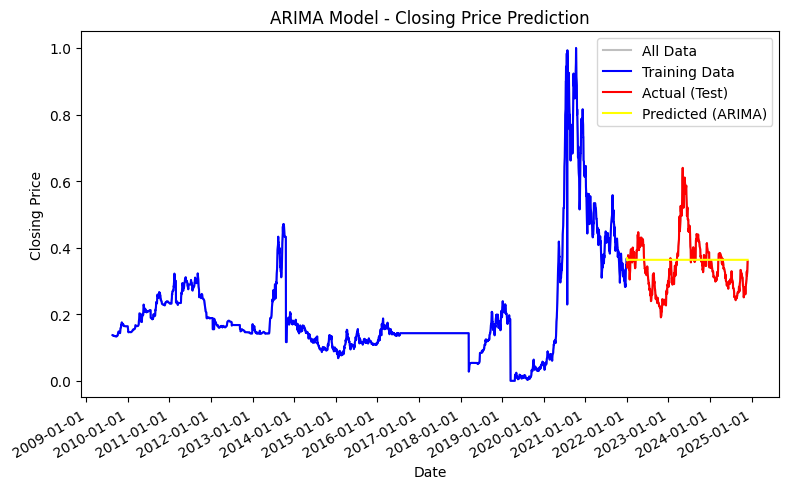

MSE: 0.007, MAE: 0.064, R-Squared: -0.060
0    0.137328
1    0.137095
2    0.136395
3    0.135929
4    0.135463
Name: close, dtype: float64
2993    0.352763
2994    0.351830
2995    0.349032
2996    0.340406
2997    0.342504
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3682   2024-11-20
3683   2024-11-23
3684   2024-11-24
3685   2024-11-25
3686   2024-11-26
Name: date, Length: 694, dtype: datetime64[ns]


In [79]:
# اطمینان از فرمت datetime ستون date
# stock_data['date'] = pd.to_datetime(stock_data['date'], format='%Y%m%d')
# stock_data = stock_data.sort_values('date')

# Split data into training (2009-2021) and testing (2022-2024) sets
train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Fit ARIMA model (initial parameters for p, d, q can be refined later)
model_arima = ARIMA(train_data, order=(5, 1, 0))  # ARIMA(5,1,0)
arima_fit = model_arima.fit()

# Make predictions
arima_predictions = arima_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics
mse_arima = mean_squared_error(test_data, arima_predictions)
mae_arima = mean_absolute_error(test_data, arima_predictions)
rsq_arima = 1 - (sum((test_data - arima_predictions)**2) / sum((test_data - np.mean(test_data))**2))

# Plot the entire dataset along with test predictions
plt.figure(figsize=(8, 5))

# Plot all data (gray)
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)

# Plot training data (blue)
plt.plot(stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['date'],
                    train_data, label='Training Data', color='blue')

# Plot actual test data (red)
plt.plot(dates_test, test_data, label='Actual (Test)', color='red')

# Plot ARIMA predictions on the test data (yellow)
plt.plot(dates_test, arima_predictions, label='Predicted (ARIMA)', color='yellow')

# Format the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Display major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # More detailed format: Year-Month-Day

# Rotate and align the tick labels for better readability
plt.gcf().autofmt_xdate()

plt.title('ARIMA Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.tight_layout()
plt.show()

# Print evaluation metrics
print(f'MSE: {mse_arima:.3f}, MAE: {mae_arima:.3f}, R-Squared: {rsq_arima:.3f}')
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)

Simple ARIMA doesn't give correct output as we only predict using single variable closing price.

Now when we try using other features including Volume, Moving Average and Volatility, it gives us better predictions.  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.001, MAE: 0.019, R-Squared: 0.914


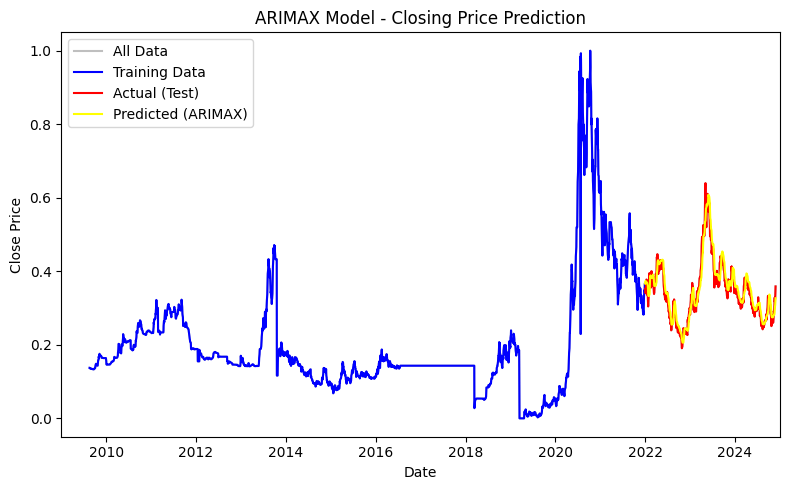

0    0.137328
1    0.137095
2    0.136395
3    0.135929
4    0.135463
Name: close, dtype: float64
2993    0.352763
2994    0.351830
2995    0.349032
2996    0.340406
2997    0.342504
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3682   2024-11-20
3683   2024-11-23
3684   2024-11-24
3685   2024-11-25
3686   2024-11-26
Name: date, Length: 694, dtype: datetime64[ns]


In [77]:
# اطمینان از فرمت datetime ستون date
# df['date'] = pd.to_datetime(df['date'], errors='coerce')
# df = df.dropna(subset=['date'])
# df = df.sort_values('date')

# Split data into training (2009-2021) and testing (2022-2024) sets
train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

# استخراج تاریخ‌های مربوط به داده‌های تست
dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Define exogenous variables (for example: Volume, MA10, Volatility)
exog_train = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')][['vol', 'MA10', 'Volatility']]
exog_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')][['vol', 'MA10', 'Volatility']]

# Fit ARIMAX model
model_arimax = ARIMA(train_data, exog=exog_train, order=(5, 0, 0))
arimax_fit = model_arimax.fit()

# Make predictions using exogenous variables for the test set
arimax_predictions = arimax_fit.forecast(steps=len(test_data), exog=exog_test)

# Evaluate performance
mse_arimax = mean_squared_error(test_data, arimax_predictions)
mae_arimax = mean_absolute_error(test_data, arimax_predictions)
rsq_arimax = 1 - (sum((test_data - arimax_predictions)**2) / sum((test_data - np.mean(test_data))**2))

print(f'MSE: {mse_arimax:.3f}, MAE: {mae_arimax:.3f}, R-Squared: {rsq_arimax:.3f}')

# Plot the results
plt.figure(figsize=(8, 5))

# Plot all data
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)

# Plot training data
plt.plot(stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['date'],
           train_data, label='Training Data', color='blue')

# Plot actual test data
plt.plot(dates_test, test_data, label='Actual (Test)', color='red')

# Plot ARIMAX predictions on the test data
plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='yellow')

# Set x-axis limits
plt.xlim(pd.to_datetime('2009-01-01'), pd.to_datetime('2025-01-01'))

plt.title('ARIMAX Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)

We can see that ARIMA with other features gave us good results. But We can't take Volume and Variability features, as they won't be available to us during predictions.

Hence we try to do predictions using Lag.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE(ARIMAX): 0.0001, MAE(ARIMAX): 0.0079, R-Squared(ARIMAX): 0.9800


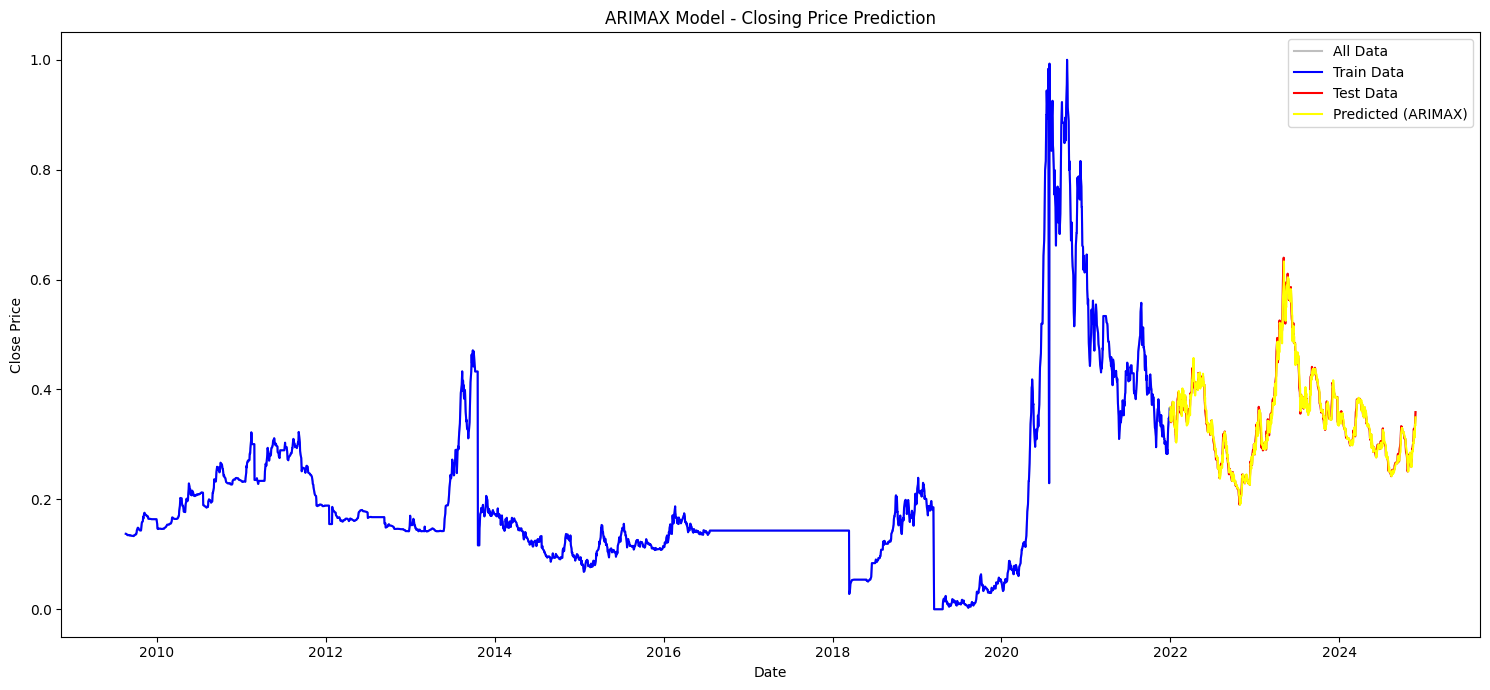

In [72]:

# اطمینان از فرمت datetime ستون date
# stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')  # تبدیل date به datetime
# stock_data = stock_data.dropna(subset=['date'])  # حذف مقادیر نامعتبر در ستون date

# # مرتب‌سازی بر اساس تاریخ
# stock_data = stock_data.sort_values('date')

# Split data into training (2009-2021) and testing (2022-2024) sets
# train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
# test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

# # استخراج تاریخ‌های مربوط به داده‌های تست
# dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Use lag features (e.g., Lag_1, Lag_2, ..., Lag_5) instead of moving averages and volatility
exog_train = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')][['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
exog_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')][['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]

# Fit ARIMAX model with lagged features as exogenous variables
model_arimax = ARIMA(train_data, exog=exog_train, order=(5, 0, 0))  # تنظیم مقادیر p, d, q
arimax_fit = model_arimax.fit()

# Make predictions using exogenous variables for the test set
arimax_predictions = arimax_fit.forecast(steps=len(test_data), exog=exog_test)

# Evaluate performance
mse_arimax = mean_squared_error(test_data, arimax_predictions)
mae_arimax = mean_absolute_error(test_data, arimax_predictions)
rsq_arimax = 1 - (sum((test_data - arimax_predictions)**2) / sum((test_data - np.mean(test_data))**2))

print(f'MSE(ARIMAX): {mse_arimax:.4f}, MAE(ARIMAX): {mae_arimax:.4f}, R-Squared(ARIMAX): {rsq_arimax:.4f}')

# Plot the results
plt.figure(figsize=(15, 7))

# نمایش کل داده‌ها به رنگ خاکستری
plt.plot(stock_data['date'], stock_data['close'], label='All Data', color='gray', alpha=0.5)

# نمایش داده‌های ترین به رنگ آبی
plt.plot(df[(stock_data['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['date'],
         train_data, label='Train Data', color='blue')

# نمایش داده‌های تست به رنگ قرمز
plt.plot(dates_test, test_data, label='Test Data', color='red')

# نمایش داده‌های پیش‌بینی‌شده به رنگ زرد
plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='yellow')

plt.title('ARIMAX Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# Prepare the data for LSTM & GRU

In [73]:
def create_dataset(data, time_step=90):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Create the LSTM input dataset
time_step = 35
X_train, Y_train = create_dataset(scaled_train_data, time_step)
X_test, Y_test = create_dataset(scaled_test_data, time_step)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


### LSTM

In [74]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.1))  # کاهش Dropout
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1))

# Compile the LSTM model with custom optimizer
optimizer = Adam(learning_rate=0.001)  # افزایش نرخ یادگیری
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer)

# Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # افزایش patience

# Train the LSTM model
history = model_lstm.fit(
    X_train, Y_train,
    epochs=200, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Inverse scaling for actual test values
Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics for LSTM
mse_lstm = mean_squared_error(Y_test_scaled, lstm_predictions)
mae_lstm = mean_absolute_error(Y_test_scaled, lstm_predictions)

ss_res = np.sum((Y_test_scaled - lstm_predictions) ** 2)
ss_tot = np.sum((Y_test_scaled - np.mean(Y_test_scaled)) ** 2)
rsq_lstm = 1 - (ss_res / ss_tot)

# Plot the LSTM results
plt.figure(figsize=(10, 6))
plt.plot(dates_test[time_step:], Y_test_scaled, label='Actual', color='blue')
plt.plot(dates_test[time_step:], lstm_predictions, label='Predicted (LSTM)', color='red')
plt.title('LSTM Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print evaluation metrics
print(f"MSE (LSTM): {mse_lstm:.5f}")
print(f"MAE (LSTM): {mae_lstm:.5f}")
print(f"R-Squared (LSTM): {rsq_lstm:.5f}")
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 8.0251e-04 - val_loss: 0.0019
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 9/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 6.6761e-04 - val_loss: 0.0078
Epoch 10/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 11/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 6.9939e-04 - val_loss: 0.0012
Epoch 12/200
84/84 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

### GRU

In [ ]:
# Build Enhanced GRU model
model_gru = Sequential()
model_gru.add(GRU(units=128, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=32))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(1))

# Compile the GRU model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # کاهش نرخ یادگیری به مقدار مناسب
model_gru.compile(loss='mean_squared_error', optimizer=optimizer)

# Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the GRU model
history = model_gru.fit(X_train, Y_train,
                        epochs=200,  # تنظیم تعداد ایپاک‌ها
                        batch_size=32,  # تنظیم سایز بچ
                        validation_split=0.1,
                        callbacks=[early_stop],
                        verbose=1)

# Predict on test data
gru_predictions = model_gru.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Inverse scaling for actual test values
Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics for GRU
mse_gru = mean_squared_error(Y_test_scaled, gru_predictions)
mae_gru = mean_absolute_error(Y_test_scaled, gru_predictions)

# Calculate R-Squared
ss_res = np.sum((Y_test_scaled - gru_predictions) ** 2)
ss_tot = np.sum((Y_test_scaled - np.mean(Y_test_scaled)) ** 2)
rsq_gru = 1 - (ss_res / ss_tot)

# Plot the GRU results
plt.figure(figsize=(10, 6))
plt.plot(dates_test[time_step:], Y_test_scaled, label='Actual', color='blue')
plt.plot(dates_test[time_step:], gru_predictions, label='Predicted (Enhanced GRU)', color='red')
plt.title('Enhanced GRU Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print evaluation metrics
print(f"MSE (Enhanced GRU): {mse_gru:.7f}")
print(f"MAE (Enhanced GRU): {mae_gru:.7f}")
print(f"R-Squared (Enhanced GRU): {rsq_gru:.5f}")
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# تنظیم داده‌ها برای مدل ARIMAX
# train_data_arimax = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
# test_data_arimax = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

# تنظیم مدل ARIMAX
arimax_model = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
arimax_result = arimax_model.fit(disp=False)

# پیش‌بینی یک ماه آینده
future_steps = 30  # 30 روز آینده
arimax_forecast = arimax_result.get_forecast(steps=future_steps).predicted_mean

# رسم پیش‌بینی ARIMAX
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[-future_steps:], test_data[-future_steps:], label='Actual', color='blue')
plt.plot(test_data.index[-future_steps:], arimax_forecast, label='Predicted (ARIMAX)', color='red')
plt.title('ARIMAX Model - 1-Month Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
# تنظیم ورودی برای پیش‌بینی آینده
future_steps = 30
input_seq = scaled_test_data[-90:]  # آخرین 90 داده برای شروع پیش‌بینی
future_predictions = []

# پیش‌بینی داده‌های آینده
for _ in range(future_steps):
    input_seq = input_seq.reshape(1, 90, 1)  # تبدیل به ابعاد مورد انتظار GRU
    pred = model_gru.predict(input_seq)  # پیش‌بینی مقدار جدید
    future_predictions.append(pred[0, 0])  # ذخیره پیش‌بینی
    pred_reshaped = pred.reshape(1, 1, 1)  # تطابق ابعاد با input_seq
    input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)  # بروزرسانی sequence

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# رسم پیش‌بینی GRU
plt.figure(figsize=(10, 6))
plt.plot(range(future_steps), future_predictions, label='Predicted (GRU)', color='red')
plt.title('GRU Model - 1-Month Ahead Prediction')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
# مشابه GRU (ورودی و پیش‌بینی)
future_steps = 30
input_seq = scaled_test_data[-90:]  # آخرین 90 داده برای شروع پیش‌بینی
future_predictions = []

# پیش‌بینی داده‌های آینده
for _ in range(future_steps):
    input_seq = input_seq.reshape(1, 90, 1)
    pred = model_lstm.predict(input_seq)
    future_predictions.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], [[pred]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# رسم پیش‌بینی LSTM
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[-future_steps:], future_predictions, label='Predicted (LSTM)', color='red')
plt.title('LSTM Model - 1-Month Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
# ترکیب پیش‌بینی‌های GRU و LSTM
combined_predictions_2 = (future_predictions_gru + future_predictions_lstm) / 2

# رسم ترکیب
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[-future_steps:], combined_predictions_2, label='Combined (GRU + LSTM)', color='green')
plt.title('Combined GRU + LSTM Model - 1-Month Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
# ترکیب پیش‌بینی‌های GRU، LSTM و ARIMAX
combined_predictions_3 = (future_predictions_gru + future_predictions_lstm + arimax_forecast) / 3

# رسم ترکیب
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[-future_steps:], combined_predictions_3, label='Combined (GRU + LSTM + ARIMAX)', color='purple')
plt.title('Combined GRU + LSTM + ARIMAX Model - 1-Month Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
